# **Anomaly Detection In Transations:**

# **Import Libraries:**

In [12]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler

In [25]:
from sklearn.model_selection import train_test_split

# **Load Dataset:**

In [8]:
df=pd.read_csv('/content/anomly detection data')

# **Understand the Data:**

In [9]:
df.shape

(1000000, 8)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   Unnamed: 0                      1000000 non-null  int64  
 1   distance_from_home              1000000 non-null  float64
 2   distance_from_last_transaction  1000000 non-null  float64
 3   ratio_to_median_purchase_price  1000000 non-null  float64
 4   repeat_retailer                 1000000 non-null  float64
 5   used_chip                       1000000 non-null  float64
 6   used_pin_number                 1000000 non-null  float64
 7   online_order                    1000000 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 61.0 MB


In [49]:
df.describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,26.628792,5.036519,1.824182,0.881536,0.350399,0.100608,0.650552
std,65.390784,25.843093,2.799589,0.323157,0.477095,0.300809,0.476796
min,0.004874,0.000118,0.004399,0.000000,0.000000,0.000000,0.000000
25%,3.878008,0.296671,0.475673,1.000000,0.000000,0.000000,0.000000
50%,9.967760,0.998650,0.997717,1.000000,0.000000,0.000000,1.000000
75%,25.743985,3.355748,2.096370,1.000000,1.000000,0.000000,1.000000
max,10632.723672,11851.104565,267.802942,1.000000,1.000000,1.000000,1.000000


In [11]:
df.head()

,Unnamed: 0,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order
0,0,57.877857,0.311140,1.945940,1.0,1.0,0.0,0.0
1,1,10.829943,0.175592,1.294219,1.0,0.0,0.0,0.0
2,2,5.091079,0.805153,0.427715,1.0,0.0,0.0,1.0
3,3,2.247564,5.600044,0.362663,1.0,1.0,0.0,1.0
4,4,44.190936,0.566486,2.222767,1.0,1.0,0.0,1.0


# **Drop useless Columns:**

In [15]:
df.drop(columns='Unnamed: 0',inplace=True)

# **Check Duplicates:**

In [22]:
df.duplicated().sum()

np.int64(0)

# **Check Null Values:**

In [24]:
df.isna().sum()

,0
distance_from_home,0
distance_from_last_transaction,0
ratio_to_median_purchase_price,0
repeat_retailer,0
used_chip,0
used_pin_number,0
online_order,0


# **Train Test Split:**

In [26]:
x_train,x_test=train_test_split(df,test_size=0.2,random_state=42)

# **Scale Data:**

In [28]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# **Apply Isolation Forest:**

In [29]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(
    n_estimators=200,
    max_samples='auto',
    contamination=0.02,
    random_state=42
)

iso_forest.fit(x_train_scaled)


IsolationForest(contamination=0.02, n_estimators=200, random_state=42)

# **Anomaly Scores and Prediction:**

In [30]:
# Scores
train_scores = iso_forest.decision_function(x_train_scaled)
test_scores = iso_forest.decision_function(x_test_scaled)

# Predictions
train_pred = iso_forest.predict(x_train_scaled)
test_pred = iso_forest.predict(x_test_scaled)

# Convert to 0/1
train_anomaly = (train_pred == -1).astype(int)
test_anomaly = (test_pred == -1).astype(int)


# **ROC-AUC:**

In [42]:
from sklearn.metrics import classification_report, roc_auc_score

print("Anomaly counts in test set predictions:")
print(pd.Series(test_anomaly).value_counts())

Anomaly counts in test set predictions:
0    195919
1      4081
Name: count, dtype: int64


#**Contamination Rate**:

We set the contamination parameter to 0.02, expecting about
 2% of the data to be anomalous.

 The model detected 4,081
 anomalies out of 200,000 test transactions, which is almost
 exactly 2.04%, very close to our expectation.

# **Visualize the distribution of anomaly scores:**

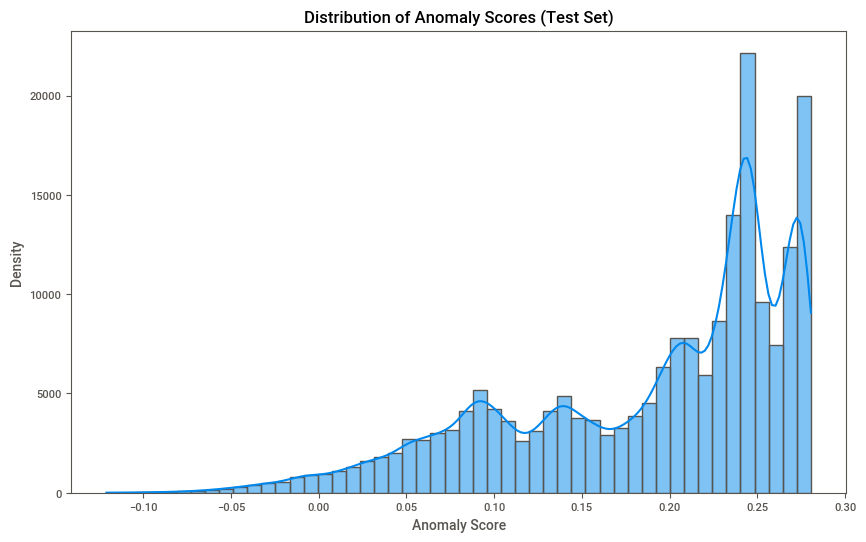

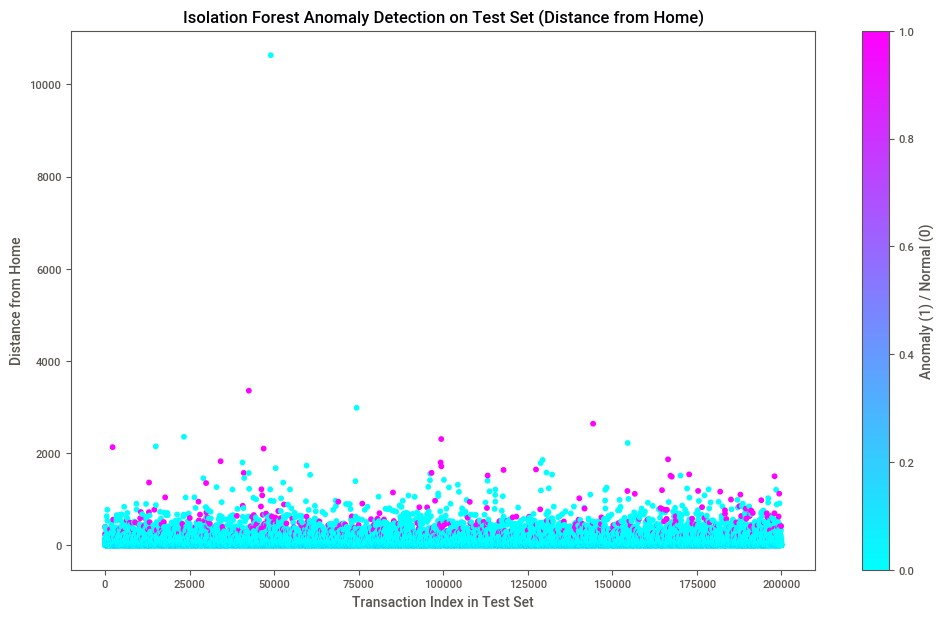

Anomaly counts in test set predictions:
0    195919
1      4081
Name: count, dtype: int64


In [41]:
plt.figure(figsize=(10, 6))
sns.histplot(test_scores, kde=True, bins=50)
plt.title('Distribution of Anomaly Scores (Test Set)')
plt.xlabel('Anomaly Score')
plt.ylabel('Density')
plt.show()

x_test_display = x_test.reset_index(drop=True)

plt.figure(figsize=(12, 7))
plt.scatter(
    x_test_display.index,
    x_test_display['distance_from_home'],
    c=test_anomaly,
    cmap='cool',
    s=10
)
plt.title('Isolation Forest Anomaly Detection on Test Set (Distance from Home)')
plt.xlabel('Transaction Index in Test Set')
plt.ylabel('Distance from Home')
plt.colorbar(label='Anomaly (1) / Normal (0)')
plt.show()

print("Anomaly counts in test set predictions:")
print(pd.Series(test_anomaly).value_counts())

# **Characteristics of the Detected Anomalies:**

In [48]:
# Create a DataFrame that includes the anomaly labels for the test set
x_test_with_anomaly = x_test_display.copy()
x_test_with_anomaly['anomaly_label'] = test_anomaly

x_test_with_anomaly[x_test_with_anomaly['anomaly_label'] == 1].describe()

,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,anomaly_label
count,4081.000000,4081.000000,4081.000000,4081.000000,4081.000000,4081.000000,4081.000000,4081.0
mean,75.536878,49.325009,5.180193,0.476354,0.512864,0.658172,0.448174,1.0
std,195.180193,127.572863,7.781797,0.499502,0.499896,0.474380,0.497368,0.0
min,0.055784,0.002157,0.023892,0.000000,0.000000,0.000000,0.000000,1.0
25%,1.050674,0.852089,0.666997,0.000000,0.000000,0.000000,0.000000,1.0
50%,1.837994,7.165998,1.985149,0.000000,1.000000,1.000000,0.000000,1.0
75%,46.517125,46.596255,6.551332,1.000000,1.000000,1.000000,1.000000,1.0
max,3353.002414,2663.513077,91.847397,1.000000,1.000000,1.000000,1.000000,1.0


# **Top 10 most Anomalous Transactions:**

In [47]:
# Add anomaly scores to the DataFrame for sorting
x_test_with_anomaly['anomaly_score'] = test_scores

x_test_with_anomaly.sort_values('anomaly_score', ascending=True).head(10)


,distance_from_home,distance_from_last_transaction,ratio_to_median_purchase_price,repeat_retailer,used_chip,used_pin_number,online_order,anomaly_label,anomaly_score
116772,1.743869,579.396643,3.264895,0.0,1.0,1.0,0.0,1,-0.120936
59579,415.087394,278.830160,0.754483,1.0,1.0,1.0,1.0,1,-0.119378
39673,0.421865,1012.837429,2.707816,0.0,1.0,1.0,0.0,1,-0.118643
59113,17.381681,280.463607,17.195546,1.0,1.0,1.0,1.0,1,-0.117351
151359,187.079948,380.811743,0.177489,1.0,1.0,1.0,0.0,1,-0.115427
46082,351.126735,52.395145,19.653784,1.0,1.0,0.0,1.0,1,-0.113369
191118,0.320555,488.428496,3.323724,0.0,0.0,1.0,0.0,1,-0.111090
57566,0.547438,256.442621,1.180218,0.0,1.0,1.0,0.0,1,-0.111052
23746,314.798756,208.725264,0.298801,1.0,0.0,1.0,0.0,1,-0.110076
144330,1.651760,110.932709,8.157767,0.0,0.0,1.0,1.0,1,-0.109234


# **Save Cleaned Dataset:**

In [50]:
df.to_csv("cleaned dataset(anomaly transations).csv", index=False)